In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 6
fig_height = 4
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/Users/hirofumi48/162348.github.io/posts/2024/Stat"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
#| code-fold: true
#| output: false
#| code-summary: サブサンプリングなしの Zig-Zag 過程のシミュレーションをする関数 ZZ1d() を定義
using ZigZagBoomerang
using Distributions
using Random
using LinearAlgebra
using Statistics  # just for sure
using StatsFuns

"""
    ∇U(i,j,ξ,x,y)
        i ∈ [d]: 次元を表すインデックス
        j ∈ [n]: サンプル番号を表すインデックス
        ξ: パラメータ空間 R^d 上の位置
        他，観測 (x,y) を引数にとる．
    この関数を実装する際，log の中身をそのまま計算しようとすると大変大きくなり，数値的に不安定になる（除算の後は 1 近くになるはずだが，Inf になってしまう）
"""
∇U(i::Int64, j::Int64, ξ, x::Matrix{Float64}, y::Vector{Float64}) = length(y) * x[i,j] * (logistic(dot(x[:,j],ξ)) - y[j])

"""
    ∇U(i,ξ,x,y)：∇U(i,j,ξ,x,y) を全データ j ∈ [n] について足し合わせたもの
        i ∈ [d]: 次元を表すインデックス
        ξ: パラメータ空間 R^d 上の位置
        他，観測 (x,y) を引数にとる．
"""
function ∇U(i::Int64, ξ, x::Matrix{Float64}, y::Vector{Float64})
    n = length(y)
    U_list = []
    for j in 1:n
        push!(U_list, ∇U(i, j, ξ, x, y))
    end
    return mean(U_list)
end

function  ∇U(ξ, x::Matrix{Float64}, y::Vector{Float64})  # 1次元の場合のショートカット
    return ∇U(1, ξ, x, y)
end

pos(x) = max(zero(x), x)

"""
    λ(i, ξ, θ, ∇U, x, y)：第 i ∈ [d] 次元のレート関数
        i ∈ [d]: 次元を表すインデックス
        (ξ,θ): E 上の座標
        ∇U
        (x,y): 観測
"""
λ(i::Int64, ξ, θ, ∇U, x, y) = pos(θ[i] * ∇U(i, ξ, x, y))
λ(ξ, θ, ∇U, x, y) = pos(θ * ∇U(ξ, x, y))  # 1次元の場合のショートカット

"""
    λ(τ, a, b)：代理レート関数の時刻 τ における値
        τ: 時間
        a,b: 1次関数の係数
"""
λ_bar(τ, a, b) = pos(a + b*τ)

"""
`x`: current location, `θ`: current velocity, `t`: current time,
"""
function move_forward(τ, t, ξ, θ, ::ZigZag1d)
    τ + t, ξ + θ*τ , θ
end

"""
    ZZ1d(∇U, ξ, θ, T, x, y, Flow; rng=Random.GLOBAL_RNG, ab=ab_Global)：ZigZag sampler without subsampling
        `∇U`: gradient of the negative log-density
        `(ξ,θ)`: initial state
        `T`: Time Horizon
        `(x,y)`: observation
        `Flow`: continuous dynamics

        `a+bt`: computational bound for intensity m(t)

        `num`: ポアソン時刻に到着した回数
        `acc`: 受容回数．`acc/num` は acceptance rate
"""
function ZZ1d(∇U, ξ, θ, T::Float64, x::Matrix{Float64}, y::Vector{Float64}, Flow::ZigZagBoomerang.ContinuousDynamics; rng=Random.GLOBAL_RNG, ab=ab_Global)
    t = zero(T)
    Ξ = [(t, ξ, θ)]
    num = acc = 0
    epoch_list = [num]
    a, b = ab(ξ, θ, x, y, Flow)
    t′ =  t + poisson_time(a, b, rand())  # イベントは a,b が定める affine proxy に従って生成する

    while t < T
        τ = t′ - t
        t, ξ, θ = move_forward(τ, t, ξ, θ, Flow)
        l, lb = λ(ξ, θ, ∇U, x, y), λ_bar(τ, a, b)  # λ が真のレート, λ_bar が affine proxy
        num += 1
        if rand()*lb < l
            acc += 1
            if l > lb + 0.01
                println(l-lb)
                println(l)
            end
            θ = -θ
            push!(Ξ, (t, ξ, θ))
            push!(epoch_list, num)
        end
        a, b = ab(ξ, θ, x, y, Flow)
        t′ = t + poisson_time(a, b, rand())
    end

    return Ξ, epoch_list, acc/num
end

ZZ1d

In [3]:
#| code-summary: global な computational bounds を定義
#| output: false

a_Global(ξ, θ, x, y) = length(y) * maximum(abs.(vec(x)))
b_Global(ξ, θ, x, y) = 0

ab_Global(ξ, θ, x, y, ::ZigZag1d) = (a_Global(ξ, θ, x, y), b_Global(ξ, θ, x, y))

ab_Global (generic function with 1 method)

In [4]:
#| echo: false
#| output: false
# T = 500.0
# (ξ0, θ0) = (0.0, 1.0)
# trace_ZZ1, epochs_ZZ1, acc_ZZ1 = ZZ1d(∇U, ξ0, θ0, T, x, y, ZigZag1d(); ab=ab_Global)
# dt = 0.01
# traj_ZZ1 = discretize(trace_ZZ1, ZigZag1d(), dt)

In [5]:
#| code-fold: true
#| code-summary: 観測を生成
#| output: false
using StatsFuns
using Distributions

ξ0 = [1.0] # True value
n_list = [10, 100, 1000]  # 実験で用いるサンプルサイズの列

Σ = [2]
x = rand(MvNormal(ξ0, Σ), n_list[end])
y = rand.(Bernoulli.(logistic.(ξ0*x)))  # BitVector になってしまう
y = Float64.(vec(y))  # Vector{Float64} に変換

1000-element Vector{Float64}:
 1.0
 1.0
 0.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 1.0
 1.0
 0.0
 0.0
 ⋮
 1.0
 1.0
 0.0
 1.0
 0.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0

In [6]:
#| echo: false
#| output: false
using JLD2

@load "Logistic2_data.jld2" x y

2-element Vector{Symbol}:
 :x
 :y

In [7]:
#| code-summary: preprocessing for ZZ-CV of complexity O(n)
#| output: false
using Statistics

"""
    U(ξ, x, y)：ポテンシャル関数
        ξ: パラメータ空間上の点
        (x,y): 観測
"""
function U(ξ, x, y)
    n = length(y)
    U_list = []
    for j in 1:n
        push!(U_list, U(j, ξ, x, y))
    end
    return mean(U_list)
end
function U(j, ξ, x, y)
    n = length(y)
    product = dot(x[:,j],ξ)
    return -n * log(exp(y[j] * product) / (1 + exp(product)))
end

using Optim

result = optimize(ξ -> U(ξ, x, y), [0.0], LBFGS())
ξ_star = Optim.minimizer(result)

function C(ξ, θ, x, y)
    n = length(y)
    max_value = maximum(x.^2)
    return n * max_value / 4
end

a_Affine(ξ, θ, x, y) = pos(θ * ∇U(ξ_star,x,y)) + C(ξ, θ, x, y) * abs(ξ - ξ_star[1])
b_Affine(ξ, θ, x, y) = C(ξ, θ, x, y)

# computational bounds for intensity m(t)
ab_Affine(ξ, θ, x, y, ::ZigZag1d) = (a_Affine(ξ, θ, x, y), b_Affine(ξ, θ, x, y))

ab_Affine (generic function with 1 method)

In [8]:
#| echo: false
#| output: false
# T = 500.0
# (ξ0, θ0) = (0.0, 1.0)
# trace_ZZ1, epochs_ZZ1, acc_ZZ1 = ZZ1d(∇U, ξ0, θ0, T, x, y, ZigZag1d(); ab=ab_Affine)
# dt = 0.01
# traj_ZZ1 = discretize(trace_ZZ1, ZigZag1d(), dt)

In [9]:
#| code-fold: true
#| output: false
#| code-summary: サブサンプリングありの Zig-Zag 過程のシミュレーションをする関数 ZZ1d_SS() と ZZ1d_CV() を定義
using ZigZagBoomerang
using Distributions
using Random
using LinearAlgebra
using Statistics  # just for sure
using StatsFuns

function λj_Global(j::Int64, ξ, θ, ∇U, x, y)
    Eʲ = ∇U(1, j, ξ, x, y)
    return pos(θ * Eʲ)
end

function ZZ1d_SS(∇U, ξ, θ, T::Float64, x::Matrix{Float64}, y::Vector{Float64}, Flow::ZigZagBoomerang.ContinuousDynamics; rng=Random.GLOBAL_RNG, ab=ab_Global)
    t = zero(T)
    Ξ = [(t, ξ, θ)]
    num = acc = 0
    epoch_list = [num]
    a, b = ab(ξ, θ, x, y, Flow)
    t′ =  t + poisson_time(a, b, rand())  # イベントは a,b が定める affine proxy に従って生成する

    while t < T
        τ = t′ - t
        t, ξ, θ = move_forward(τ, t, ξ, θ, Flow)
        j = rand(1:length(y))
        l, lb = λj_Global(j, ξ, θ, ∇U, x, y), λ_bar(τ, a, b)  # λ が真のレート, λ_bar が affine proxy
        num += 1
        if rand()*lb < l
            acc += 1
            if l > lb + 0.01
                println(l-lb)
            end
            θ = -θ
            push!(Ξ, (t, ξ, θ))
            push!(epoch_list, num)
        end
        a, b = ab(ξ, θ, x, y, Flow)
        t′ = t + poisson_time(a, b, rand())
    end

    return Ξ, epoch_list, acc/num
end

function λj(j::Int64, ξ, θ, ∇U, x, y)
    Eʲ = ∇U(ξ_star, x, y) + ∇U(1, j, ξ, x, y) - ∇U(1, j, ξ_star, x, y)
    return pos(θ * Eʲ)
end

function ZZ1d_CV(∇U, ξ, θ, T::Float64, x::Matrix{Float64}, y::Vector{Float64}, Flow::ZigZagBoomerang.ContinuousDynamics; rng=Random.GLOBAL_RNG, ab=ab_Affine)
    t = zero(T)
    Ξ = [(t, ξ, θ)]
    num = acc = 0
    epoch_list = [num]
    a, b = ab(ξ, θ, x, y, Flow)
    t′ =  t + poisson_time(a, b, rand())  # イベントは a,b が定める affine proxy に従って生成する

    while t < T
        τ = t′ - t
        t, ξ, θ = move_forward(τ, t, ξ, θ, Flow)
        j = rand(1:length(y))
        l, lb = λj(j, ξ, θ, ∇U, x, y), λ_bar(τ, a, b)  # λ が真のレート, λ_bar が affine proxy
        num += 1
        if rand()*lb < l
            acc += 1
            if l > lb + 0.01
                println(l-lb)
            end
            θ = -θ
            push!(Ξ, (t, ξ, θ))
            push!(epoch_list, num)
        end
        a, b = ab(ξ, θ, x, y, Flow)
        t′ = t + poisson_time(a, b, rand())
    end

    return Ξ, epoch_list, acc/num
end

ZZ1d_CV (generic function with 1 method)

In [10]:
#| code-summary: サブサンプリングなしの実験を実行する関数 experiment_ZZ() を定義
#| code-fold: true
#| eval: false
using Statistics

function ESS(samples::Vector{Float64}, T, dt)
    B = T / dt
    V = (dt / T) * sum(samples.^2) - ((dt / T) * sum(samples))^2
    Y = samples .* sqrt(T / B)
    ESS = T * V / var(Y)
    return ESS
end

function getESSperEpoch(ab, T ,dt, x, y; ξ0=0.0, θ0=1.0)
    trace, epochs, acc = ZZ1d(∇U, ξ0, θ0, T, x, y, ZigZag1d(); ab=ab)
    traj = discretize(trace, ZigZag1d(), dt)
    return ESS(traj.x, T, dt) / epochs[end]
end

N = 10
T = 500.0
dt = 0.1

function experiment_ZZ(N, T, dt; ξ0=0.0, θ0=1.0, n_list=[10, 100, 1000])  # サブサンプリングなしの ZZ() に関して N 回実験
    ESSs_sum_Affine = zero(n_list)
    ESSs_sum_Global = zero(n_list)

    for _ in 1:N
        ESSs_Affine = []
        ESSs_Global = []
        for n in n_list
            push!(ESSs_Affine, getESSperEpoch(ab_Affine, T, dt, x[:,1:n], y[1:n]; ξ0=ξ0, θ0=θ0))
            push!(ESSs_Global, getESSperEpoch(ab_Global, T, dt, x[:,1:n], y[1:n]; ξ0=ξ0, θ0=θ0))
        end
        ESSs_sum_Affine = [ESSs_sum_Affine ESSs_Affine]
        ESSs_sum_Global = [ESSs_sum_Global ESSs_Global]
    end
    return mean(ESSs_sum_Affine, dims=2), var(ESSs_sum_Affine, dims=2), mean(ESSs_sum_Global, dims=2), var(ESSs_sum_Global, dims=2)
end

# ESS_Affine, var_ESS_Affine, ESS_Global, var_ESS_Global = experiment_ZZ(2, T, dt; ξ0=0.0, θ0=1.0, n_list=n_list)

In [11]:
#| code-summary: 実験には 10分 かかるので，保持した実行結果を用いる
#| output: false
#| code-fold: true
using JLD2

@load "Logistic2_Experiment1.jld2" ESS_Affine var_ESS_Affine ESS_Global var_ESS_Global

4-element Vector{Symbol}:
 :ESS_Affine
 :var_ESS_Affine
 :ESS_Global
 :var_ESS_Global

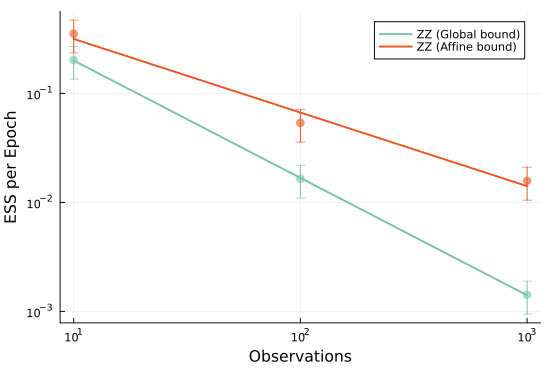

In [12]:
#| code-summary: 結果をプロット
#| code-fold: true
#| echo: false
#| output: false
using Plots
using GLM, DataFrames

function startPlot(n_list, ESS, var_ESS; label="ZZ (Global bound)", background_color=false, color="#78C2AD")
    if background_color
        p = plot(#n_list, ESS,
        xscale=:log10,
        yscale=:log10,
        xlabel="Observations",
        ylabel="ESS per Epoch",
        background_color = "#F0F1EB"
        )
    else
        p = plot(#n_list, ESS,
        xscale=:log10,
        yscale=:log10,
        xlabel="Observations",
        ylabel="ESS per Epoch"
        )
    end

    scatter!(p, n_list, ESS,
            yerror=var_ESS,
            markerstrokecolor=color,
            marker=:circle,
            markersize=5,
            markeralpha=0.6,
            color=color,
            label=nothing
            )

    df = DataFrame(X = log10.(n_list), Y = log10.(vec(ESS)))
    model = lm(@formula(Y ~ X), df)
    X_pred = range(minimum(df.X), maximum(df.X), length=100)
    Y_pred = predict(model, DataFrame(X = X_pred))
    plot!(p, 10 .^ X_pred, 10 .^ Y_pred,
        line=:solid,
        linewidth=2,
        color=color,
        label=label
        )

    return p
end

function addPlot(p, n_list, ESS, var_ESS; label="ZZ (Affine bound)", color="#E95420")
    q = scatter(p, n_list, ESS,
            yerror=var_ESS,
            markerstrokecolor=color,
            marker=:circle,
            markersize=5,
            markeralpha=0.6,
            color=color,
            label=nothing
            )

    df = DataFrame(X = log10.(n_list), Y = log10.(vec(ESS)))
    model = lm(@formula(Y ~ X), df)
    X_pred = range(minimum(df.X), maximum(df.X), length=100)
    Y_pred = predict(model, DataFrame(X = X_pred))
    plot!(q, 10 .^ X_pred, 10 .^ Y_pred,
        line=:solid,
        linewidth=2,
        color=color,
        label=label
        )
    
    return q
end

p = startPlot(n_list, ESS_Global, sqrt.(var_ESS_Global)#; background_color=true
)
q = addPlot(p, n_list, ESS_Affine, sqrt.(var_ESS_Affine))
display(q)

In [13]:
#| code-summary: サブサンプリング付きの実験を実行する関数 experiment_ZZ() を定義
#| code-fold: true
#| eval: false
using Statistics

# function ESS(samples::Vector{Float64}, T, dt)
#     B = T / dt
#     V = (dt / T) * sum(samples.^2) - ((dt / T) * sum(samples))^2
#     Y = samples .* sqrt(T / B)
#     ESS = T * V / var(Y)
#     return ESS
# end

function getESSperEpoch_SS(ab, ZZ, T ,dt, x, y; ξ0=0.0, θ0=1.0)
    trace, epochs, acc = ZZ(∇U, ξ0, θ0, T, x, y, ZigZag1d(); ab=ab)
    traj = discretize(trace, ZigZag1d(), dt)
    return ESS(traj.x, T, dt) * length(y) / epochs[end]  # サブサンプリングをしているので length(y) で補正する必要あり
end

N = 10
T = 500.0
dt = 0.1

function experiment_ZZ_SS(N, T, dt; ξ0=0.0, θ0=1.0, n_list=[10, 100, 1000])  # サブサンプリングなしの ZZ() に関して N 回実験
    ESSs_sum_CV = zero(n_list)
    ESSs_sum_SS = zero(n_list)

    for _ in 1:N
        ESSs_CV = []
        ESSs_SS = []
        for n in n_list
            push!(ESSs_CV, getESSperEpoch_SS(ab_Affine, ZZ1d_CV, T, dt, x[:,1:n], y[1:n]; ξ0=ξ0, θ0=θ0))
            push!(ESSs_SS, getESSperEpoch_SS(ab_Global, ZZ1d_SS, T, dt, x[:,1:n], y[1:n]; ξ0=ξ0, θ0=θ0))
        end
        ESSs_sum_CV = [ESSs_sum_CV ESSs_CV]
        ESSs_sum_SS = [ESSs_sum_SS ESSs_SS]
    end
    return mean(ESSs_sum_CV, dims=2), var(ESSs_sum_CV, dims=2), mean(ESSs_sum_SS, dims=2), var(ESSs_sum_SS, dims=2)
end

# ESS_CV, var_ESS_CV, ESS_SS, var_ESS_SS = experiment_ZZ_SS(2, T, dt; ξ0=0.0, θ0=1.0, n_list=n_list)

In [14]:
#| echo: false
#| output: false
@load "Logistic2_Experiment2.jld2" ESS_CV var_ESS_CV ESS_SS var_ESS_SS

4-element Vector{Symbol}:
 :ESS_CV
 :var_ESS_CV
 :ESS_SS
 :var_ESS_SS

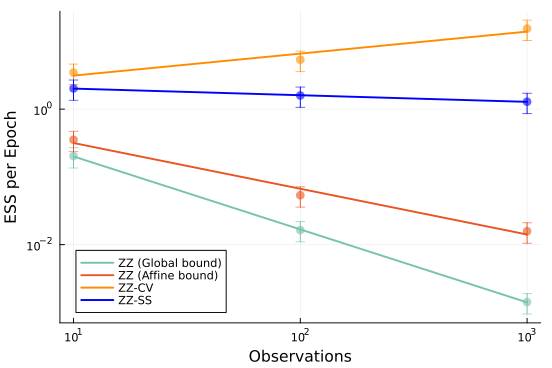

In [15]:
#| code-summary: 結果をプロット
#| code-fold: true

q = addPlot(q, n_list, ESS_CV, sqrt.(var_ESS_CV); label="ZZ-CV", color="darkorange")
q = addPlot(q, n_list, ESS_SS, sqrt.(var_ESS_SS); label="ZZ-SS", color="blue")
q = plot!(q, legend=:bottomleft)
display(q)

In [16]:
#| echo: false
#| output: false
#| eval: false
savefig(q, "Logistic2_ESS_per_Epoch.svg")

In [17]:
#| output: false
#| code-fold: true
#| code-summary: MALA によるサンプリングを実行
using AdvancedHMC, AdvancedMH, ForwardDiff
using LogDensityProblems
using LogDensityProblemsAD
using StructArrays
using LinearAlgebra

struct LogTargetDensity
    x::Matrix{Float64}
    y::Vector{Float64}
end

LogDensityProblems.logdensity(p::LogTargetDensity, ξ) = -U(ξ, p.x, p.y)
LogDensityProblems.dimension(p::LogTargetDensity) = 1
LogDensityProblems.capabilities(::Type{LogTargetDensity}) = LogDensityProblems.LogDensityOrder{0}()

model_with_ad = LogDensityProblemsAD.ADgradient(Val(:ForwardDiff), LogTargetDensity(x, y))

σ² = 0.0001
spl = MALA(x -> MvNormal((σ² / 2) .* x, σ² * I))

chain = sample(model_with_ad, spl, 2000; initial_params=ξ0, chain_type=StructArray, param_names=["ξ"], stats=true)

traj_MALA = chain.ξ

Sampling:   1%|▍                                        |  ETA: 0:00:11

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


2000-element Vector{Float64}:
 1.0
 0.9974224374513315
 0.9919224541472944
 0.9925780700770707
 0.9927576203595331
 0.9919995337557838
 1.0029714990348129
 0.998974789410466
 1.028807745390316
 1.0304117420733525
 1.0310318919292774
 1.0273531566512646
 1.0303553106768633
 ⋮
 0.9429208519908852
 0.9336162474082821
 0.9371500525313982
 0.9347747368046142
 0.9416347882576841
 0.9465251631553865
 0.9511733742854217
 0.9652987126734853
 0.9572449927735426
 0.9605278476591075
 0.9561900138552324
 0.9465624067543426

In [18]:
#| output: false
a_IS(ξ, θ, x, y) = sum(abs.(x))
b_IS(ξ, θ, x, y) = 0

ab_IS(ξ, θ, x, y, ::ZigZag1d) = (a_IS(ξ, θ, x, y), b_IS(ξ, θ, x, y))

ab_IS (generic function with 1 method)

In [19]:
#| code-fold: true
#| output: false
using StatsBase

function λj_IS(j::Int64, ξ, θ, ∇U, x, y)
    pj = abs(x[1,j]) / sum(abs.(x))
    Eʲ = ∇U(1, j, ξ, x, y) / (length(y) * pj)
    return pos(θ * Eʲ)
end

function ZZ1d_IS(∇U, ξ, θ, T::Float64, x::Matrix{Float64}, y::Vector{Float64}, Flow::ZigZagBoomerang.ContinuousDynamics; rng=Random.GLOBAL_RNG, ab=ab_IS)
    t = zero(T)
    Ξ = [(t, ξ, θ)]
    num = acc = 0
    epoch_list = [num]
    a, b = ab(ξ, θ, x, y, Flow)
    t′ =  t + poisson_time(a, b, rand())  # イベントは a,b が定める affine proxy に従って生成する
    n = length(y)

    while t < T
        τ = t′ - t
        t, ξ, θ = move_forward(τ, t, ξ, θ, Flow)
        j = sample(1:n, Weights(vec(x)))
        l, lb = λj_IS(j, ξ, θ, ∇U, x, y), λ_bar(τ, a, b)  # λ が真のレート, λ_bar が affine proxy
        num += 1
        if rand()*lb < l
            acc += 1
            if l > lb + 0.01
                println(l-lb)
            end
            θ = -θ
            push!(Ξ, (t, ξ, θ))
            push!(epoch_list, num)
        end
        a, b = ab(ξ, θ, x, y, Flow)
        t′ = t + poisson_time(a, b, rand())
    end

    return Ξ, epoch_list, acc/num
end

ZZ1d_IS (generic function with 1 method)

In [20]:
#| eval: false
#| code-fold: true
function experiment_ZZ_IS(N, T, dt; ξ0=0.0, θ0=1.0, n_list=[10, 100, 1000])  # 重点サブサンプリング ZZ1d_IS() に関して N 回実験
    ESSs_sum_IS = zero(n_list)

    for _ in 1:N
        ESSs_IS = []
        for n in n_list
            push!(ESSs_IS, getESSperEpoch_SS(ab_IS, ZZ1d_IS, T, dt, x[:,1:n], y[1:n]; ξ0=ξ0, θ0=θ0))
        end
        ESSs_sum_IS = [ESSs_sum_IS ESSs_IS]
    end
    return mean(ESSs_sum_IS, dims=2), var(ESSs_sum_IS, dims=2)
end

ESS_IS, var_ESS_IS = experiment_ZZ_IS(2, 500.0, 1.0; ξ0=0.0, θ0=1.0, n_list=n_list)

In [21]:
#| code-fold: true
#| output: false
@load "Logistic2_Experiment3_.jld2" ESS_IS var_ESS_IS

2-element Vector{Symbol}:
 :ESS_IS
 :var_ESS_IS

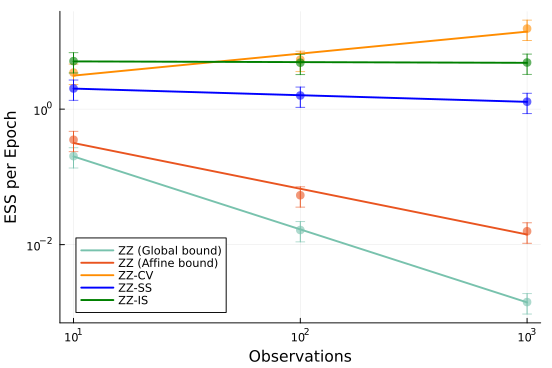

In [22]:
#| code-fold: true
#| code-summary: 結果をプロット
r = addPlot(q, n_list, ESS_IS, sqrt.(var_ESS_IS); label="ZZ-IS", color="green")
display(r)

In [23]:
#| echo: false
#| output: false
#| eval: false
savefig(r, "Logistic2.svg")

In [24]:
ξ0 = [1.0] # True value
Σ = [2]
n_list = [10, 100, 1000]

function sample_SparseData(n::Int64, α::Float64; ρ=MvNormal(ξ0, Σ))
    x = []
    while length(x) < n
        rand() < α ? push!(x, rand(ρ)[1]) : push!(x, 0.0)
    end
    x = Float64.(reshape(x,1,:))
    y = rand.(Bernoulli.(logistic.(ξ0*x)))
    y = Float64.(vec(y))
    return x, y
end

x_Sparse, y_Sparse = sample_SparseData(1000, 0.1)

([0.0 0.0 … 0.0 0.0], [0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0  …  0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [25]:
#| code-summary: データを生成して ZZ で実行
#| eval: false
using StatsFuns
using Distributions

"""
    U(ξ, x, y)：ポテンシャル関数
        ξ: パラメータ空間上の点
        (x,y): 観測
"""
function U(ξ, x, y)
    n = length(y)
    U_list = []
    for j in 1:n
        push!(U_list, U(j, ξ, x, y))
    end
    return mean(U_list)
end
function U(j, ξ, x, y)
    n = length(y)
    product = dot(x[:,j],ξ)
    return -n * exp(y[j] * product) / (1 + exp(product))
end

ξ0 = [1,2]  # True value
n_list = [10, 100, 1000, 10000]  # 実験で用いるサンプルサイズの列

Σ = [2 0; 0 2]
x = rand(MvNormal(ξ0, Σ), n_list[end])
y = rand.(Bernoulli.(logistic.(ξ0'*x)))  # BitVector になってしまう
y = Float64.(vec(y))  #  Vector{Float64} に変換

In [26]:
#| eval: false
using Optim

result = optimize(ξ -> U(ξ,x,y), [0.0,0.0], LBFGS())
ξ_star = Optim.minimizer(result)